# GP on aberrations:
- c1, a1x, a1y  full grid values are [-1, 1], [-1, 1] and [-1, 1]- say 10 in ech direction- total 1000 sets of 3
- Sample c1, a1x, a1y --> 20 seed points  in that range--> (c1_i, a1_i, a1y_i) for i in [1, 20]
- get haadf-image (512*512) for each  (c1_i, a1_i, a1y_i) for i in [1, 20]
- compute contrast: np.std(normalized_image_data) / np.average(normalized_image_data)
- train a GP on seed points
- infer GP on the entire data - 


Tips:
- How to handle cuda device etc- later 
- fastest way to simulate- later

### AH notebook is here - https://github.com/AustinHouston/pystemsim/blob/main/Ex_for_SmartTuning.ipynb

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib ipympl

import secrets
from ase.io import read
from ase.visualize import view
import abtem
from abtem.atoms import orthogonalize_cell
import pyTEMlib.probe_tools as pt

import sys
sys.path.append('..')  # Add parent directory to path

from pystemsim import data_generator as dg



You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
You don't have gwyfile installed.     If you wish to open .gwy files, you will need to      install it (pip install gwyfile) before attempting.
Using kinematic_scattering library version 0.2022.1.0  by G.Duscher


In [2]:
# ========== SETUP STEM SIMULATOR ==========
print("Setting up STEM simulator...")
xtal = read('../crystal_files/WS2.cif')
from abtem.atoms import orthogonalize_cell
xtal, transform = orthogonalize_cell(xtal, allow_transform=True, return_transform=True)
xtal = xtal * (30, 20, 1)

pixel_size = 0.106
fov = 96
frame = (0, fov, 0, fov)
potential = dg.create_pseudo_potential(xtal, pixel_size, sigma=1, bounds=frame, atom_frame=11)

# Setup probe aberrations
ab = pt.get_target_aberrations("Spectra300", 60000)
ab['acceleration_voltage'] = 60e3
ab['FOV'] = fov / 12
ab['convergence_angle'] = 30
ab['wavelength'] = pt.get_wavelength(ab['acceleration_voltage'])
ab['C10'] = 0
ab['C12a'] = 0
ab['C12b'] = 0

def contrast_rms(im):
    """Calculate RMS contrast"""
    return np.std(im) / np.mean(im)

def get_stem_image_contrast(c10, c12a, c12b):
    """Generate STEM image and return contrast for given aberrations"""
    ab['C10'] = c10
    ab['C12a'] = c12a
    ab['C12b'] = c12b
    
    probe = dg.get_probe(ab, potential)
    image = dg.convolve_kernel(potential, probe)
    noisy_image = dg.lowfreq_noise(image, noise_level=0.5, freq_scale=0.04)
    sim_im = dg.poisson_noise(noisy_image, counts=1e7)
    
    contrast = contrast_rms(np.array(sim_im))
    return contrast, sim_im

Setting up STEM simulator...


## ========== gaussian process SETUP ==========

In [10]:
import numpy as np
import torch
import botorch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition import UpperConfidenceBound
from botorch.optim import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)


In [11]:
# Parameter ranges based on your exploration
param_ranges = {
    'C10': (-8, 8),    # defocus
    'C12a': (-10, 10), # twofold astigmatism (a)
    'C12b': (-10, 10)  # twofold astigmatism (b)
}

In [12]:
# Create full grid (coarser for computational efficiency)
n_grid = 7  # 7^3 = 343 points
c10_grid = np.linspace(*param_ranges['C10'], n_grid)
c12a_grid = np.linspace(*param_ranges['C12a'], n_grid)
c12b_grid = np.linspace(*param_ranges['C12b'], n_grid)
C10, C12A, C12B = np.meshgrid(c10_grid, c12a_grid, c12b_grid, indexing='ij')
full_grid = np.stack([C10.flatten(), C12A.flatten(), C12B.flatten()], axis=1)

In [21]:
# Sample seed points
n_seed = 50
seed_indices = np.random.choice(len(full_grid), n_seed, replace=False)
seed_points = full_grid[seed_indices]

In [22]:
# ========== QUERY SEED POINTS ==========
print(f"\nQuerying {n_seed} seed points...")
seed_scores = []
seed_images = []

for i, (c10, c12a, c12b) in enumerate(seed_points):
    contrast, sim_im = get_stem_image_contrast(c10, c12a, c12b)
    seed_scores.append(contrast)
    seed_images.append(sim_im)
    print(f"Seed {i+1}/{n_seed}: C10={c10:.2f}, C12a={c12a:.2f}, C12b={c12b:.2f}, contrast={contrast:.4f}")

seed_scores = np.array(seed_scores)


Querying 50 seed points...
0.03
Seed 1/50: C10=2.67, C12a=10.00, C12b=6.67, contrast=0.3686
0.03
Seed 2/50: C10=-2.67, C12a=3.33, C12b=-3.33, contrast=0.4923
0.03
Seed 3/50: C10=-8.00, C12a=-6.67, C12b=0.00, contrast=0.5618
0.03
Seed 4/50: C10=-5.33, C12a=0.00, C12b=10.00, contrast=0.3478
0.03
Seed 5/50: C10=8.00, C12a=-3.33, C12b=-3.33, contrast=0.4536
0.03
Seed 6/50: C10=-5.33, C12a=0.00, C12b=0.00, contrast=0.4940
0.03
Seed 7/50: C10=2.67, C12a=-3.33, C12b=0.00, contrast=0.5540
0.03
Seed 8/50: C10=-5.33, C12a=10.00, C12b=10.00, contrast=0.3700
0.03
Seed 9/50: C10=0.00, C12a=-3.33, C12b=-3.33, contrast=0.4428
0.03
Seed 10/50: C10=2.67, C12a=3.33, C12b=6.67, contrast=0.4037
0.03
Seed 11/50: C10=8.00, C12a=3.33, C12b=-3.33, contrast=0.4349
0.03
Seed 12/50: C10=0.00, C12a=0.00, C12b=3.33, contrast=0.5662
0.03
Seed 13/50: C10=2.67, C12a=3.33, C12b=-10.00, contrast=0.3707
0.03
Seed 14/50: C10=2.67, C12a=6.67, C12b=-6.67, contrast=0.3831
0.03
Seed 15/50: C10=-2.67, C12a=-10.00, C12b=0.00,

In [23]:
# Find best seed point
best_seed_idx = np.argmax(seed_scores)
best_seed = seed_points[best_seed_idx]
print(f"\nBest seed point: C10={best_seed[0]:.2f}, C12a={best_seed[1]:.2f}, C12b={best_seed[2]:.2f}")
print(f"Best seed contrast: {seed_scores[best_seed_idx]:.4f}")


Best seed point: C10=0.00, C12a=0.00, C12b=3.33
Best seed contrast: 0.5662


In [24]:
# ========== TRAIN GP ==========
print("\nTraining GP model...")
train_X = torch.tensor(seed_points, dtype=torch.float64)
train_Y = torch.tensor(seed_scores, dtype=torch.float64).unsqueeze(-1)

gp_model = SingleTaskGP(train_X, train_Y)
mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
fit_gpytorch_mll(mll)


Training GP model...


/nfs/home/upratius/.conda/envs/qBO/lib/python3.10/site-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): LogNormalPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): LogNormalPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): RBFKernel(
      (lengthscale_prior): LogNormalPrior()
      (raw_lengthscale_constraint): GreaterThan(2.500E-02)
    )
    (outcome_transform): Standardize()
  )
)

In [25]:
# ========== PREDICT ON GRID ==========
print("Making predictions on full grid...")
test_X = torch.tensor(full_grid, dtype=torch.float64)
gp_model.eval()

with torch.no_grad():
    posterior = gp_model.posterior(test_X)
    predictions = posterior.mean.numpy().flatten()
    uncertainties = posterior.variance.sqrt().numpy().flatten()

best_pred_idx = np.argmax(predictions)
best_pred_params = full_grid[best_pred_idx]
print(f"\nBest predicted point: C10={best_pred_params[0]:.2f}, C12a={best_pred_params[1]:.2f}, C12b={best_pred_params[2]:.2f}")
print(f"Predicted contrast: {predictions[best_pred_idx]:.4f}")

Making predictions on full grid...

Best predicted point: C10=0.00, C12a=0.00, C12b=3.33
Predicted contrast: 0.5653


In [19]:

# ========== VERIFY BEST PREDICTION ==========
print("\nVerifying best predicted point...")
best_contrast, best_image = get_stem_image_contrast(*best_pred_params)
print(f"Actual contrast at best predicted point: {best_contrast:.4f}")


Verifying best predicted point...
0.03
Actual contrast at best predicted point: 0.5406



=== GP Diagnostic ===
Number of seed points: 50
Grid size: 343
Best prediction is a seed point: True


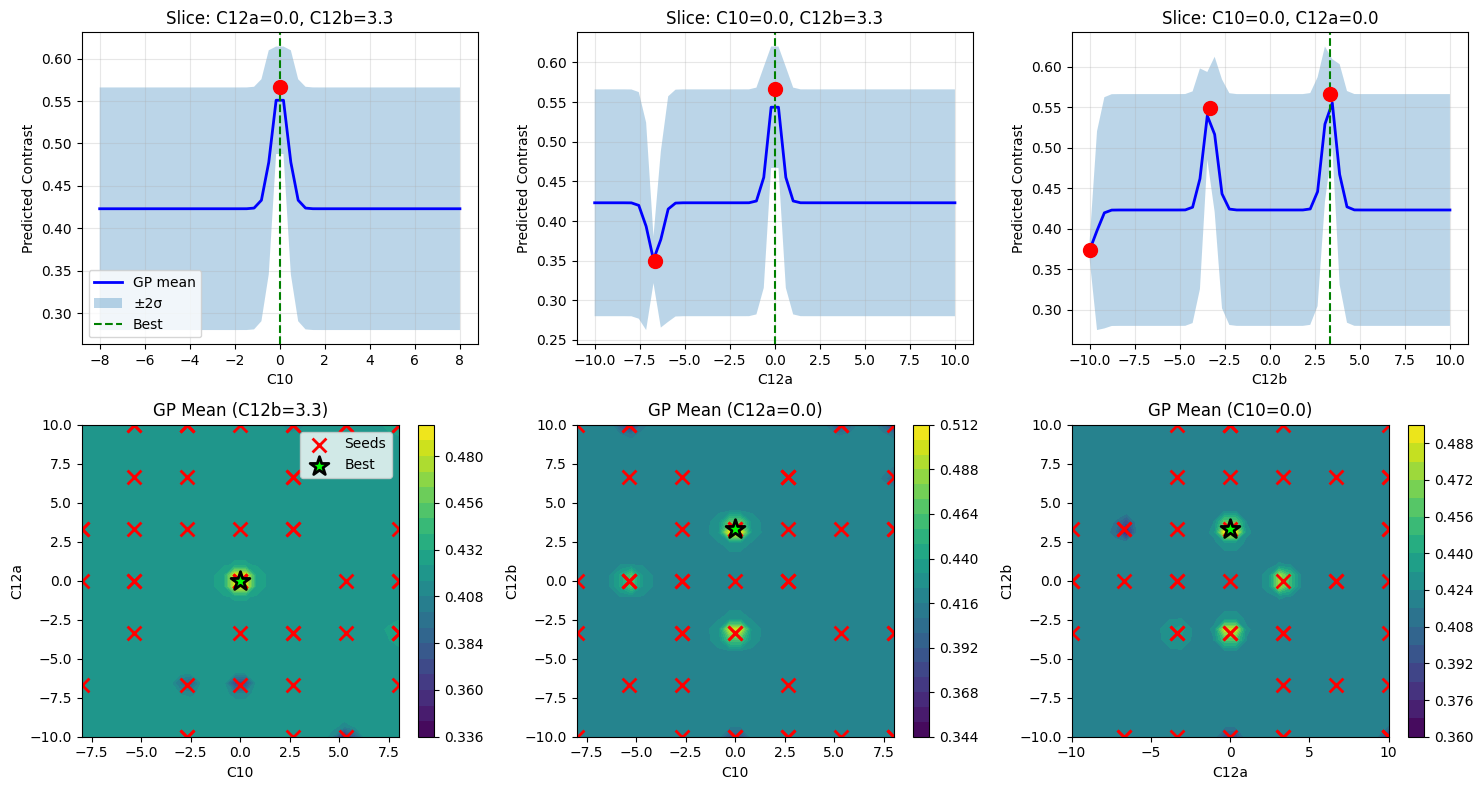

<Figure size 640x480 with 0 Axes>

In [30]:
# ========== SIMPLE POSTERIOR DIAGNOSTICS ==========

# 1. Check if GP is just memorizing
print("\n=== GP Diagnostic ===")
print(f"Number of seed points: {n_seed}")
print(f"Grid size: {len(full_grid)}")
print(f"Best prediction is a seed point: {best_pred_idx in seed_indices}")

# 2. Simple 1D slices through best point
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

best_c10, best_c12a, best_c12b = best_pred_params

# Slice 1: Vary C10, fix others
c10_range = np.linspace(*param_ranges['C10'], 50)
slice_points = np.array([[c10, best_c12a, best_c12b] for c10 in c10_range])
slice_X = torch.tensor(slice_points, dtype=torch.float64)

with torch.no_grad():
    post = gp_model.posterior(slice_X)
    mean = post.mean.numpy().flatten()
    std = post.variance.sqrt().numpy().flatten()

axes[0, 0].plot(c10_range, mean, 'b-', linewidth=2, label='GP mean')
axes[0, 0].fill_between(c10_range, mean - 2*std, mean + 2*std, alpha=0.3, label='±2σ')
# Plot seed points on this slice
for i, (c10, c12a, c12b) in enumerate(seed_points):
    if np.abs(c12a - best_c12a) < 2 and np.abs(c12b - best_c12b) < 2:
        axes[0, 0].scatter(c10, seed_scores[i], c='red', s=100, zorder=5)
axes[0, 0].axvline(best_c10, color='green', linestyle='--', label='Best')
axes[0, 0].set_xlabel('C10')
axes[0, 0].set_ylabel('Predicted Contrast')
axes[0, 0].set_title(f'Slice: C12a={best_c12a:.1f}, C12b={best_c12b:.1f}')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Slice 2: Vary C12a, fix others
c12a_range = np.linspace(*param_ranges['C12a'], 50)
slice_points = np.array([[best_c10, c12a, best_c12b] for c12a in c12a_range])
slice_X = torch.tensor(slice_points, dtype=torch.float64)

with torch.no_grad():
    post = gp_model.posterior(slice_X)
    mean = post.mean.numpy().flatten()
    std = post.variance.sqrt().numpy().flatten()

axes[0, 1].plot(c12a_range, mean, 'b-', linewidth=2)
axes[0, 1].fill_between(c12a_range, mean - 2*std, mean + 2*std, alpha=0.3)
for i, (c10, c12a, c12b) in enumerate(seed_points):
    if np.abs(c10 - best_c10) < 2 and np.abs(c12b - best_c12b) < 2:
        axes[0, 1].scatter(c12a, seed_scores[i], c='red', s=100, zorder=5)
axes[0, 1].axvline(best_c12a, color='green', linestyle='--')
axes[0, 1].set_xlabel('C12a')
axes[0, 1].set_ylabel('Predicted Contrast')
axes[0, 1].set_title(f'Slice: C10={best_c10:.1f}, C12b={best_c12b:.1f}')
axes[0, 1].grid(True, alpha=0.3)

# Slice 3: Vary C12b, fix others
c12b_range = np.linspace(*param_ranges['C12b'], 50)
slice_points = np.array([[best_c10, best_c12a, c12b] for c12b in c12b_range])
slice_X = torch.tensor(slice_points, dtype=torch.float64)

with torch.no_grad():
    post = gp_model.posterior(slice_X)
    mean = post.mean.numpy().flatten()
    std = post.variance.sqrt().numpy().flatten()

axes[0, 2].plot(c12b_range, mean, 'b-', linewidth=2)
axes[0, 2].fill_between(c12b_range, mean - 2*std, mean + 2*std, alpha=0.3)
for i, (c10, c12a, c12b) in enumerate(seed_points):
    if np.abs(c10 - best_c10) < 2 and np.abs(c12a - best_c12a) < 2:
        axes[0, 2].scatter(c12b, seed_scores[i], c='red', s=100, zorder=5)
axes[0, 2].axvline(best_c12b, color='green', linestyle='--')
axes[0, 2].set_xlabel('C12b')
axes[0, 2].set_ylabel('Predicted Contrast')
axes[0, 2].set_title(f'Slice: C10={best_c10:.1f}, C12a={best_c12a:.1f}')
axes[0, 2].grid(True, alpha=0.3)

# Bottom row: 2D slices with contours
# C10 vs C12a (fix C12b = best)
c10_mesh = np.linspace(*param_ranges['C10'], 30)
c12a_mesh = np.linspace(*param_ranges['C12a'], 30)
C10_mesh, C12A_mesh = np.meshgrid(c10_mesh, c12a_mesh)
grid_2d = np.column_stack([C10_mesh.ravel(), C12A_mesh.ravel(), 
                           np.full(C10_mesh.size, best_c12b)])
grid_2d_X = torch.tensor(grid_2d, dtype=torch.float64)

with torch.no_grad():
    post = gp_model.posterior(grid_2d_X)
    mean_2d = post.mean.numpy().reshape(C10_mesh.shape)

contour = axes[1, 0].contourf(C10_mesh, C12A_mesh, mean_2d, levels=20, cmap='viridis')
axes[1, 0].scatter(seed_points[:, 0], seed_points[:, 1], c='red', s=100, 
                   marker='x', linewidths=2, label='Seeds')
axes[1, 0].scatter(best_c10, best_c12a, c='lime', s=200, marker='*', 
                   edgecolors='black', linewidths=2, label='Best')
axes[1, 0].set_xlabel('C10')
axes[1, 0].set_ylabel('C12a')
axes[1, 0].set_title(f'GP Mean (C12b={best_c12b:.1f})')
axes[1, 0].legend()
plt.colorbar(contour, ax=axes[1, 0])

# C10 vs C12b (fix C12a = best)
c12b_mesh = np.linspace(*param_ranges['C12b'], 30)
C10_mesh, C12B_mesh = np.meshgrid(c10_mesh, c12b_mesh)
grid_2d = np.column_stack([C10_mesh.ravel(), 
                           np.full(C10_mesh.size, best_c12a),
                           C12B_mesh.ravel()])
grid_2d_X = torch.tensor(grid_2d, dtype=torch.float64)

with torch.no_grad():
    post = gp_model.posterior(grid_2d_X)
    mean_2d = post.mean.numpy().reshape(C10_mesh.shape)

contour = axes[1, 1].contourf(C10_mesh, C12B_mesh, mean_2d, levels=20, cmap='viridis')
axes[1, 1].scatter(seed_points[:, 0], seed_points[:, 2], c='red', s=100, 
                   marker='x', linewidths=2)
axes[1, 1].scatter(best_c10, best_c12b, c='lime', s=200, marker='*', 
                   edgecolors='black', linewidths=2)
axes[1, 1].set_xlabel('C10')
axes[1, 1].set_ylabel('C12b')
axes[1, 1].set_title(f'GP Mean (C12a={best_c12a:.1f})')
plt.colorbar(contour, ax=axes[1, 1])

# C12a vs C12b (fix C10 = best)
C12A_mesh, C12B_mesh = np.meshgrid(c12a_mesh, c12b_mesh)
grid_2d = np.column_stack([np.full(C12A_mesh.size, best_c10),
                           C12A_mesh.ravel(), 
                           C12B_mesh.ravel()])
grid_2d_X = torch.tensor(grid_2d, dtype=torch.float64)

with torch.no_grad():
    post = gp_model.posterior(grid_2d_X)
    mean_2d = post.mean.numpy().reshape(C12A_mesh.shape)

contour = axes[1, 2].contourf(C12A_mesh, C12B_mesh, mean_2d, levels=20, cmap='viridis')
axes[1, 2].scatter(seed_points[:, 1], seed_points[:, 2], c='red', s=100, 
                   marker='x', linewidths=2)
axes[1, 2].scatter(best_c12a, best_c12b, c='lime', s=200, marker='*', 
                   edgecolors='black', linewidths=2)
axes[1, 2].set_xlabel('C12a')
axes[1, 2].set_ylabel('C12b')
axes[1, 2].set_title(f'GP Mean (C10={best_c10:.1f})')
plt.colorbar(contour, ax=axes[1, 2])

plt.tight_layout()
# plt.savefig('gp_posterior_slices.png', dpi=150, bbox_inches='tight')
plt.show()



plt.tight_layout()
# plt.savefig('gp_predictions_dist.png', dpi=150, bbox_inches='tight')
plt.show()